The gameplan for this notebook is nothing novel, simply re-doing some stuff from https://arxiv.org/abs/1812.04170:

* For both k-regular and E-R (Erdos-Reyni) graphs: 

    a) For p=1, run qaoa on one instance of the graph, see how well those parameters do on other instances of the same size
    
    b) Take the same parameters from above and repeat but for larger graphs but with the same properties (k-regular) or E-R with same probability for picking edges
    
Once we get comfortable doing this process we can look at graph algorithms other than max-cut, or start seeing if QAOA on maxcut can distinguish other interesting graph properties

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import qiskit
from qiskit import BasicAer
from qiskit.optimization.ising import max_cut
import qiskit.optimization.ising.common as common
from qiskit.aqua import QuantumInstance
from qiskit.aqua.components.optimizers.nlopts.esch import ESCH
from qiskit.aqua.algorithms import QAOA
from qiskit.quantum_info import Pauli
from qiskit.aqua.operators.weighted_pauli_operator import WeightedPauliOperator
import pandas as pd
import random

### Helpful Functions

In [17]:
#brute force find max cut on graph with adjacency matrix adj
def maxCutBrute(adj):
    bestCostBrute = 0
    n = len(adj)
    for b in range(2**n):
        x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
        cost = 0
        for i in range(n):
            for j in range(n):
                cost = cost + adj[i, j]*x[i]*(1-x[j])
        if bestCostBrute < cost:
            bestCostBrute = cost
            xBestBrute = x
    return xBestBrute, int(bestCostBrute)

In [18]:
def generateRegularGraphs(n, k, numGraphs):
    # find the most common max-cut value for typical instances 
    testGraphProfits = []
    for i in range(15):
        newGraph = nx.random_graphs.random_regular_graph(k, n)
        newAdj = nx.convert_matrix.to_numpy_matrix(newGraph)
        testGraphProfits.append(maxCutBrute(newAdj)[1])
        targetMaxCutProfit = max(set(testGraphProfits), key=testGraphProfits.count)
    graphs = []
    numGenerated = 0
    #avoid infinite loop by putting reasonable target values !!!
    while numGenerated < numGraphs:
        newGraph = nx.random_graphs.random_regular_graph(k, n)
        newAdj = nx.convert_matrix.to_numpy_matrix(newGraph)
        brute = maxCutBrute(newAdj)[1]
        if brute == targetMaxCutProfit:
            graphs.append(newGraph)
            numGenerated += 1
    return graphs

In [19]:
def generatePauliList(adj):
    #Converts adjacency matrix into a list of Pauli z operators (idk what the x part does)
    numNodes = adj.shape[0]
    pauliList = []
    for i in range(numNodes):
        for j in range(i):
            if adj[i, j] != 0:
                xp = np.zeros(numNodes, dtype=np.bool)
                zp = np.zeros(numNodes, dtype=np.bool)
                zp[i] = True
                zp[j] = True
                pauliList.append([0.5 * adj[i, j], Pauli(zp, xp)])
    return WeightedPauliOperator(paulis=pauliList)

In [20]:
# generate parameter list with pSteps betas followed by pSteps gammas with 0<beta<pi and 0<gamma<2pi
def generateRandomInitialPoint(pSteps):
    return list(np.pi * np.append(np.random.rand(pSteps), 2 * np.random.rand(pSteps)))

In [21]:
#Note from above, our goal is to maximum #egdes/2 - 1/2*sum(z_i*z_j) but we are equivalently minimizing 1/2*sum(z_i*z_j)
#Therefore the true energy is offset - (calculated min energy) where offset is #edges/2
#Initial point is of form [pSteps betas where 0<beta<pi, pSteps gammas where 0<gamma<2*pi]
def maxCutQAOA(nShots, pSteps, qubitOp, offset, maxEvals, initialPoint = None):
    backend = BasicAer.get_backend('qasm_simulator')
    quantumInstance = QuantumInstance(backend, shots=nShots)
    if initialPoint != None:
        qaoa = QAOA(qubitOp, ESCH(max_evals=maxEvals), p=pSteps, initial_point = initialPoint)
    else:
        qaoa = QAOA(qubitOp, ESCH(max_evals=maxEvals), p=pSteps)
    result = qaoa.run(quantumInstance)
    #State-vectors in result are written LSB (0th vertex is last qubit)
    solution = max_cut.get_graph_solution(common.sample_most_likely(result['eigvecs'][0]))
    return {'result':result, 'energy': -result['energy'] + offset, 'params':result['opt_params'], 'solution':solution}

In [22]:
def generateResults(graphList, nShots, pSteps, maxEvals, initialPoint=None):
    # return qaoa data for all graphs in graphList   
    results = []
    for g in graphList:
        adj = nx.convert_matrix.to_numpy_matrix(g)
        bruteCut = maxCutBrute(adj)
        operator = generatePauliList(adj)
        qaoaResult = maxCutQAOA(nShots, pSteps, operator, g.number_of_edges()/2, maxEvals, initialPoint=initialPoint)
        params = np.round(qaoaResult['params'], 5)
        energy = qaoaResult['energy']
        result = [params, qaoaResult['solution'], energy, bruteCut[0], bruteCut[1], energy/bruteCut[1]]
        results.append(result)
    return np.array(results)

# convert data generated by generateResults to pandas DataFrame
def resultDataToTable(result):
    return pd.DataFrame(result, columns = ["Parameters", "Sampled QAOA vector", "QAOA vector profit", 
                                          "Best vector", "Best vector profit", "QAOA/Best profit"])

# return mean and deviation of data generated by generateResults
def resultDataStats(result):
    qaoaProfit, optimumProfit = result.T[2], np.mean(result.T[4])
    mean, stdev = np.round(np.mean(qaoaProfit),3), np.round(np.std(qaoaProfit),3)
    return {'mean': mean, 'st dev': stdev, 'fraction': mean/optimumProfit, 'dev fraction':stdev/optimumProfit}

### 4-Regular Graphs Example

A note: You can find the number of non-isomorphi k-regular n node graphs here (copied for small n below): https://oeis.org/A051031/table
The easist to read is the triangular table, the rows correspond to number of nodes starting with 1 at the top
The columns correspond to degree starting with 0 on the left.

n=1:  1	
n=2:  1		1	
n=3:  1		0		1	
n=4:  1		1		1		1	
n=5:  1		0		1		0		1	
n=6:  1		1		2		2		1		1	
n=7:  1		0		2		0		2		0		1	
n=8:  1		1		3		6		6		3		1		1	
n=9:  1		0		4		0		16		0		4		0		1	
n=10: 1		1		5		21		60		60		21		5		1		1

We'll start with n=8, k=4, so we have at least 6 non-isomorphic graphs to work with. We first find optimal parameters for one instance of a 4-regular 8 vertex graph

/Users/victorli/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


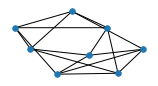

In [8]:
n8k4_base = nx.random_graphs.random_regular_graph(4, 8)
plt.figure(figsize = (2,1))
nx.draw(n8k4_base, node_size=30, alpha=1)

In [9]:
nShots, pSteps = 256, 2
maxEvals = 75
n8k4_baseData = generateResults([n8k4_base], nShots, pSteps, maxEvals)
n8k4_baseTable = resultDataToTable(n8k4_baseData)
n8k4_baseTable
print('So some good angles are beta, gamma = ', n8k4_baseData[0][0])

So some good angles are beta, gamma =  [1.86056 0.07479 2.42325 0.7504 ]


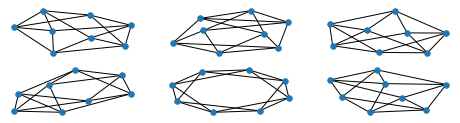

In [10]:
#generate #numPlots random k-reg graphs on n nodes using networx
n8k4_numPlots = 6 #plz make a multiple of 2 or else my bitchass plotting function wont work
n8k4_graphs = generateRegularGraphs(8, 4, n8k4_numPlots)
plt.figure(figsize = (8,2))
for i in range(n8k4_numPlots):
    plt.subplot(2, n8k4_numPlots//2, i+1) 
    nx.draw(n8k4_graphs[i], node_size=30, alpha=1)
plt.show()

In [11]:
# n8k4_baseData[0][0] holds the optimal parameters from our n8k4_base run
n8k4_optimalData = generateResults(n8k4_graphs, nShots, pSteps, 1, list(n8k4_baseData[0][0]))
n8k4_optimalTable = resultDataToTable(n8k4_optimalData)
n8k4_optimalStats = resultDataStats(n8k4_optimalData)
print('Mean qaoa profit:', n8k4_optimalStats['mean'], '. Deviation of qaoa profit', n8k4_optimalStats['st dev'])
n8k4_optimalTable

Mean qaoa profit: 9.533 . Deviation of qaoa profit 0.062


,Parameters,Sampled QAOA vector,QAOA vector profit,Best vector,Best vector profit,QAOA/Best profit
0,"[1.86056, 0.07479, 2.42325, 0.7504]","[0, 1, 0, 0, 0, 0, 1, 1]",9.52344,"[1, 0, 1, 1, 0, 1, 0, 0]",12,0.79362
1,"[1.86056, 0.07479, 2.42325, 0.7504]","[0, 0, 1, 0, 1, 0, 0, 1]",9.50781,"[0, 1, 1, 0, 1, 0, 0, 0]",12,0.792318
2,"[1.86056, 0.07479, 2.42325, 0.7504]","[1, 1, 1, 0, 1, 0, 0, 1]",9.59375,"[1, 0, 0, 0, 1, 0, 1, 0]",12,0.799479
3,"[1.86056, 0.07479, 2.42325, 0.7504]","[1, 0, 1, 0, 0, 0, 0, 1]",9.41406,"[0, 1, 0, 0, 1, 1, 0, 0]",12,0.784505
4,"[1.86056, 0.07479, 2.42325, 0.7504]","[1, 1, 0, 0, 1, 1, 0, 0]",9.5625,"[1, 1, 0, 0, 1, 1, 0, 0]",12,0.796875
5,"[1.86056, 0.07479, 2.42325, 0.7504]","[1, 0, 0, 1, 0, 1, 1, 0]",9.59375,"[1, 0, 0, 0, 1, 1, 0, 0]",12,0.799479


What if we tried with some random parameters, rather than the optimal parameters for some instance?

In [12]:
# Try with random beta and gamma, within allowable ranges by IBM QAOA (pi and 2pi respectively)
n8k4_randomInitialPoint = list(np.pi * np.append(np.random.rand(pSteps), 2 * np.random.rand(pSteps)))
n8k4_randomData = generateResults(n8k4_graphs, nShots, pSteps, 1, n8k4_randomInitialPoint)
n8k4_randomTable = resultDataToTable(n8k4_randomData)
n8k4_randomStats = resultDataStats(n8k4_randomData)
print('mean qaoa profit:', n8k4_randomStats['mean'], '. Deviation of qaoa profit:', n8k4_randomStats['st dev'])
n8k4_randomTable

mean qaoa profit: 7.013 . Deviation of qaoa profit: 0.102


,Parameters,Sampled QAOA vector,QAOA vector profit,Best vector,Best vector profit,QAOA/Best profit
0,"[1.02657, 0.01443, 6.14785, 4.06286]","[0, 0, 0, 0, 0, 1, 0, 0]",7.04688,"[1, 0, 1, 1, 0, 1, 0, 0]",12,0.58724
1,"[1.02657, 0.01443, 6.14785, 4.06286]","[1, 1, 1, 1, 1, 1, 1, 1]",7.09375,"[0, 1, 1, 0, 1, 0, 0, 0]",12,0.591146
2,"[1.02657, 0.01443, 6.14785, 4.06286]","[1, 1, 1, 0, 1, 1, 1, 1]",6.97656,"[1, 0, 0, 0, 1, 0, 1, 0]",12,0.58138
3,"[1.02657, 0.01443, 6.14785, 4.06286]","[0, 0, 0, 0, 0, 0, 0, 1]",7.04688,"[0, 1, 0, 0, 1, 1, 0, 0]",12,0.58724
4,"[1.02657, 0.01443, 6.14785, 4.06286]","[1, 1, 1, 1, 1, 1, 1, 1]",6.80469,"[1, 1, 0, 0, 1, 1, 0, 0]",12,0.567057
5,"[1.02657, 0.01443, 6.14785, 4.06286]","[0, 0, 0, 0, 0, 1, 0, 0]",7.10938,"[1, 0, 0, 0, 1, 1, 0, 0]",12,0.592448


Noice! The profit concentrates for random and optimal parameters :0

So far we can now do everything on the chart on page 8 of https://arxiv.org/abs/1812.04170, provided we can find "Low" parameters, or those that minimize the qaoa maxcut profit, which we could do by trying a bunch of random angles

## Scaling n
#### How do optimal parameters for small n scale to larger n? Lets start with 4 regular graphs again

In [23]:
# Find the optimal parameters for p=1 qaoa on 8 node 4-regular graphs
n8k4_graph = nx.random_graphs.random_regular_graph(4, 8)
nShots, pSteps, maxEvals = 256, 1, 75
n8k4_graphData = generateResults([n8k4_graph], nShots, pSteps, maxEvals)
n8k4_params = list(n8k4_graphData[0][0])
print('8 node 4 reg graph qaoa trained optimality:', n8k4_graphData[0][2]/n8k4_graphData[0][4])

# Test how this scales to 10 node graphs
k4_numPlots = 6 
n10k4_graphs = generateRegularGraphs(10, 4, k4_numPlots)
n10k4_optimalData = generateResults(n10k4_graphs, nShots, pSteps, 1, n8k4_params)
n10k4_optimalStats = resultDataStats(n10k4_optimalData)
print('10 nodes optimum:\n', 'Mean qaoa profit:', n10k4_optimalStats['mean'], ', Deviation of qaoa profit', 
      n10k4_optimalStats['st dev'], ', Qaoa profit optimality', n10k4_optimalStats['fraction'])

# compare to randomly chosen parameters
n10k4_initParams = generateRandomInitialPoint(1)
n10k4_randomData = generateResults(n10k4_graphs, nShots, pSteps, 1, n10k4_initParams)
n10k4_randomStats = resultDataStats(n10k4_randomData)
print('10 nodes random:\n', 'Mean qaoa profit:', n10k4_randomStats['mean'], ', Deviation of qaoa profit', 
      n10k4_randomStats['st dev'], ', Qaoa profit optimality', n10k4_randomStats['fraction'])

8 node 4 reg graph qaoa trained optimality: 0.8014322916666666


In [ ]:
# how about 15 node graphs? WARNING THIS TAKES ~10 MIN ON MY PC
n15k4_graphs = generateRegularGraphs(15, 4, k4_numPlots)
n15k4_optimalData = generateResults(n15k4_graphs, nShots, pSteps, 1, n8k4_params)
n15k4_optimalStats = resultDataStats(n15k4_optimalData)
print('15 nodes optimum:\n', 'Mean qaoa profit:', n15k4_optimalStats['mean'], ', Deviation of qaoa profit', 
      n15k4_optimalStats['st dev'], ', Qaoa profit optimality', n15k4_optimalStats['fraction'])

# compare to randomly chosen parameters
n15k4_initParams = generateRandomInitialPoint(1)
n15k4_randomData = generateResults(n15k4_graphs, nShots, pSteps, 1, n15k4_initParams)
n15k4_randomStats = resultDataStats(n15k4_randomData)
print('15 nodes random:\n', 'Mean qaoa profit:', n15k4_randomStats['mean'], ', Deviation of qaoa profit', 
      n15k4_randomStats['st dev'], ', Qaoa profit optimality', n15k4_randomStats['fraction'])

15 nodes optimum:
 Mean qaoa profit: 18.59 , Deviation of qaoa profit 0.054 , Qaoa profit optimality 0.7745833333333333


It looks like the parameters for n=8 actually work even better than for n=10 and n=15